# Ella Rises Data Analysis
Group 1-11 <br>
Brady Bates, Peter Young, Caydn Baldwin, Jacob Woodward

# Data Import and Preview

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import linregress
from scipy.stats import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df = pd.read_csv('https://www.dropbox.com/scl/fi/092g4qahxqomym7ror6if/NewFirstNormalFormAlph.csv?rlkey=mjk757q5aqrfvublxmi66vnd6&st=5e9id1j7&dl=1', encoding="cp1252")
df.head()



,Email,FirstName,LastName,DateOfBirth,Role,Phone,City,State,ZipCode,Organization,...,SurveyNPSBucket,SurveyComments,SurveySubmissionDate,MilestoneNumber,MilestoneTitle,MilestoneDate,DonationNumber,DonationDate,DonationAmount,TotalDonations
0,aaliyah.brown434@ellarises.org,Aaliyah,Brown,12/4/2010 0:00,participant,801-414-3762,Riverton,UT,84281.0,Retail Store,...,NaN,NaN,NaN,1.0,BS in Mechanical Engineering,12/4/2030,1.0,10/5/2023,264.32,264.32
1,aaliyah.brown434@ellarises.org,Aaliyah,Brown,12/4/2010 0:00,participant,801-414-3762,Riverton,UT,84281.0,Retail Store,...,Passive,"At first, I met people who want to collaborate...",10/27/2024 5:29,1.0,BS in Mechanical Engineering,12/4/2030,1.0,10/5/2023,264.32,264.32
2,aaliyah.brown434@ellarises.org,Aaliyah,Brown,12/4/2010 0:00,participant,801-414-3762,Riverton,UT,84281.0,Retail Store,...,NaN,NaN,NaN,1.0,BS in Mechanical Engineering,12/4/2030,1.0,10/5/2023,264.32,264.32
3,aaliyah.davis1088@ellarises.org,Aaliyah,Davis,12/21/1999 0:00,participant,801-411-3641,St. George,UT,84589.0,Cafe Rio,...,Promoter,"In my opinion, the hands-on segment tied every...",8/29/2025 12:22,1.0,BS in Mechanical Engineering,4/3/2026,NaN,NaN,NaN,NaN
4,aaliyah.jones207@community.org,Aaliyah,Jones,11/17/2000 0:00,participant,801-729-6644,Riverton,UT,84697.0,Startup Lab,...,Promoter,The Arduino demo during Data Science Study Gro...,5/23/2025 2:20,1.0,High School Diploma,12/16/2025,NaN,NaN,NaN,NaN


This code read in the data and displayed the first few rows.

# Data Manipulation and Cleaning

In [ ]:
# --- 1. Setup Base Participants ---
static_cols = ['Email', 'FirstName', 'LastName', 'DateOfBirth', 'Role',
               'City', 'State', 'ZipCode', 'Organization', 'FieldOfInterest']
df_participants = df[static_cols].drop_duplicates('Email').set_index('Email')


# --- 2. Process Events Separately ---
event_cols = ['Email', 'EventName', 'EventType', 'EventStart', 'RegistrationStatus',
              'SurveySatisfactionScore', 'SurveyUsefulnessScore', 'SurveyInstructorScore',
              'SurveyRecommendationScore', 'SurveyOverallScore']

unique_events = df[event_cols].drop_duplicates(subset=['Email', 'EventName', 'EventStart'])
attended_events = unique_events[unique_events['RegistrationStatus'] == 'attended']

events_agg = attended_events.groupby('Email').agg(
    TotalEventsAttended=('EventName', 'count'),
    AvgSatisfaction=('SurveySatisfactionScore', 'mean'),
    AvgOverallScore=('SurveyOverallScore', 'mean')
)

events_by_type = attended_events.pivot_table(
    index='Email', columns='EventType', values='EventName',
    aggfunc='count', fill_value=0
).add_prefix('EventCount_')


# --- 3. Process Donations Separately ---
donation_cols = ['Email', 'DonationNumber', 'DonationAmount']
unique_donations = df[donation_cols].drop_duplicates(subset=['Email', 'DonationNumber'])
unique_donations = unique_donations.dropna(subset=['DonationNumber'])

donations_agg = unique_donations.groupby('Email')['DonationAmount'].sum().rename('TotalDonationAmount')


# --- 4. Process Milestones Separately (UPDATED) ---
milestone_cols = ['Email', 'MilestoneNumber', 'MilestoneTitle']
unique_milestones = df[milestone_cols].drop_duplicates(subset=['Email', 'MilestoneNumber']).copy()
unique_milestones = unique_milestones.dropna(subset=['MilestoneNumber'])

# A. Define a categorization function
def get_milestone_category(title):
    title = str(title).lower()
    # Check for diplomas/degrees
    if any(x in title for x in ['diploma', 'degree', 'bs ', 'ba ', 'ms ', 'mba', 'mfa', 'aa ', 'as ', 'phd']):
        return 'Diploma'
    # Check for projects
    elif 'project' in title:
        return 'Project'
    # Everything else
    else:
        return 'Work/Award/Other'

# B. Apply the category
unique_milestones['MilestoneCategory'] = unique_milestones['MilestoneTitle'].apply(get_milestone_category)

# C. Calculate Total Count
milestones_total = unique_milestones.groupby('Email')['MilestoneNumber'].count().rename('MilestoneCount')

# D. Calculate Counts by Category (Pivot)
milestones_by_type = unique_milestones.pivot_table(
    index='Email',
    columns='MilestoneCategory',
    values='MilestoneNumber',
    aggfunc='count',
    fill_value=0
).add_suffix('MilestoneCount')
# This results in columns like: DiplomaMilestoneCount, ProjectMilestoneCount, Work/Award/OtherMilestoneCount


# --- 5. Merge All Tables ---
# Join all parts: Participants + Events Agg + Events Type + Donations + Milestones Total + Milestones Type
df_final = df_participants.join([
    events_agg,
    events_by_type,
    donations_agg,
    milestones_total,
    milestones_by_type
], how='left')

# Fill NaNs with 0 for all count/sum columns
# We dynamically get the column names from the pivots to ensure we catch them all
count_cols = ['TotalEventsAttended', 'TotalDonationAmount', 'MilestoneCount'] + \
             list(events_by_type.columns) + \
             list(milestones_by_type.columns)

df_final[count_cols] = df_final[count_cols].fillna(0)

# Rename these columns to make more sense
df_final = df_final.rename(columns={"EventCount_Annual Conference": "EventCount_AnnualConference"})
df_final = df_final.rename(columns={"MilestoneCount": "TotalMilestoneCount"})


df = df_final
#Drop row with all missing values
df = df[df.isna().sum(axis=1) <= 5]
#Drop "admin" rows.
df = df[df["Role"] != "admin"]

df.head()



,FirstName,LastName,DateOfBirth,Role,City,State,ZipCode,Organization,FieldOfInterest,TotalEventsAttended,...,AvgOverallScore,EventCount_AnnualConference,EventCount_Arts,EventCount_Leadership,EventCount_STEM,TotalDonationAmount,TotalMilestoneCount,DiplomaMilestoneCount,ProjectMilestoneCount,Work/Award/OtherMilestoneCount
Email,,,,,,,,,,,,,,,,,,,,,
aaliyah.brown434@ellarises.org,Aaliyah,Brown,12/4/2010 0:00,participant,Riverton,UT,84281.0,Retail Store,STEM,3.0,...,4.00,0.0,0.0,1.0,2.0,264.32,1.0,1.0,0.0,0.0
aaliyah.davis1088@ellarises.org,Aaliyah,Davis,12/21/1999 0:00,participant,St. George,UT,84589.0,Cafe Rio,Arts,1.0,...,4.50,0.0,1.0,0.0,0.0,0.00,1.0,1.0,0.0,0.0
aaliyah.jones207@community.org,Aaliyah,Jones,11/17/2000 0:00,participant,Riverton,UT,84697.0,Startup Lab,Both,1.0,...,4.50,0.0,0.0,0.0,1.0,0.00,1.0,1.0,0.0,0.0
aaliyah.king483@studentmail.org,Aaliyah,King,7/29/2001 0:00,participant,Orem,UT,84534.0,SLCC,Both,1.0,...,3.75,0.0,1.0,0.0,0.0,0.00,1.0,1.0,0.0,0.0
aaliyah.martinez937@community.org,Aaliyah,Martinez,3/1/1999 0:00,participant,Lehi,UT,84265.0,Valley Charter,STEM,1.0,...,4.50,0.0,0.0,0.0,1.0,0.00,2.0,1.0,0.0,1.0


This code block transforms the raw participant dataset, which contains multiple rows per participant due to repeated events, donations, and milestones, into a flattened, analysis-ready table with one row per participant. It first extracts static demographic information for each participant, then separately aggregates events, donations, and milestones. For events, it counts total attendance, computes average survey scores, and pivots event types into separate features. Donations and milestones are similarly aggregated into total amounts and counts. Milestones are also categorized based on if they are diploma, project, or other milestones. Finally, all aggregated tables are merged back with the participant table using Email as the key, and missing numeric values are filled with zero. The result is a clean, structured dataframe suitable for statistical modeling or predictive analysis, where each row represents a single participant with summary features capturing their activity and engagement.<br>

We dropped admin rows since we want to explore data of the participants of Ella Rises and including the admins would mess up our data.

In [ ]:
print("\nInfo:\n")
df.info()
print("\nDescribe:\n")
df.describe()
print("\nISNA table: \n")
print(df.isna().sum())
print("\nShape: \n")
df.shape


Info:

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, aaliyah.brown434@ellarises.org to zoey.young545@studentmail.org
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   FirstName                       1172 non-null   object 
 1   LastName                        1172 non-null   object 
 2   DateOfBirth                     1172 non-null   object 
 3   Role                            1172 non-null   object 
 4   City                            1172 non-null   object 
 5   State                           1172 non-null   object 
 6   ZipCode                         1172 non-null   float64
 7   Organization                    1172 non-null   object 
 8   FieldOfInterest                 1172 non-null   object 
 9   TotalEventsAttended             1172 non-null   float64
 10  AvgSatisfaction                 925 non-null    float64
 11  AvgOverallScore                 925 no

(1172, 21)

This code block helps us overview the flattened data. We notice that many of these columns are stored as float data instead of integer and the birthday isn't stored as a date. We also only have missing data in survey responses, which is what we expect (we don't want to autofill any data for individuals that haven't attended events or filled out surveys).

In [ ]:

df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')

int_columns = [
    "TotalMilestoneCount",
    "EventCount_STEM",
    "EventCount_Leadership",
    "EventCount_Arts",
    "EventCount_AnnualConference",
    "TotalEventsAttended",
    "ZipCode",
    "DiplomaMilestoneCount",
    "Work/Award/OtherMilestoneCount",
    "ProjectMilestoneCount"

]

for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("int64")

#Adding a calculated age column based on date of birth
df["Age"] = (pd.Timestamp("now") - df['DateOfBirth']).dt.days / 365.25

print("\nInfo:\n")
df.info()
df.head()


Info:

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, aaliyah.brown434@ellarises.org to zoey.young545@studentmail.org
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   FirstName                       1172 non-null   object        
 1   LastName                        1172 non-null   object        
 2   DateOfBirth                     1172 non-null   datetime64[ns]
 3   Role                            1172 non-null   object        
 4   City                            1172 non-null   object        
 5   State                           1172 non-null   object        
 6   ZipCode                         1172 non-null   int64         
 7   Organization                    1172 non-null   object        
 8   FieldOfInterest                 1172 non-null   object        
 9   TotalEventsAttended             1172 non-null   int64         
 10  AvgSatisfaction

,FirstName,LastName,DateOfBirth,Role,City,State,ZipCode,Organization,FieldOfInterest,TotalEventsAttended,...,EventCount_AnnualConference,EventCount_Arts,EventCount_Leadership,EventCount_STEM,TotalDonationAmount,TotalMilestoneCount,DiplomaMilestoneCount,ProjectMilestoneCount,Work/Award/OtherMilestoneCount,Age
Email,,,,,,,,,,,,,,,,,,,,,
aaliyah.brown434@ellarises.org,Aaliyah,Brown,2010-12-04,participant,Riverton,UT,84281,Retail Store,STEM,3,...,0,0,1,2,264.32,1,1,0,0,14.997947
aaliyah.davis1088@ellarises.org,Aaliyah,Davis,1999-12-21,participant,St. George,UT,84589,Cafe Rio,Arts,1,...,0,1,0,0,0.00,1,1,0,0,25.952088
aaliyah.jones207@community.org,Aaliyah,Jones,2000-11-17,participant,Riverton,UT,84697,Startup Lab,Both,1,...,0,0,0,1,0.00,1,1,0,0,25.043121
aaliyah.king483@studentmail.org,Aaliyah,King,2001-07-29,participant,Orem,UT,84534,SLCC,Both,1,...,0,1,0,0,0.00,1,1,0,0,24.347707
aaliyah.martinez937@community.org,Aaliyah,Martinez,1999-03-01,participant,Lehi,UT,84265,Valley Charter,STEM,1,...,0,0,0,1,0.00,2,1,0,1,26.759754


This code block converted all columns that should be integers to integers. We left the average score columns as floats as they will have decimals (and also still have missing values as expected). We also left total donation amount as a float since it will have decimals. We see that there are 1172 individuals in the data.

# Univariate Analysis (Numeric)

TotalMilestoneCount Column: 

count    1172.000000
mean        1.262799
std         0.677224
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: TotalMilestoneCount, dtype: float64
Median: 1.0
IQR: 1.0
Stdev: 0.6769347323095598
Skew: 0.8463909984017527


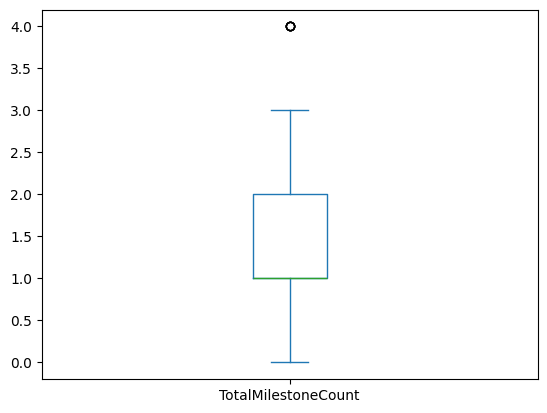

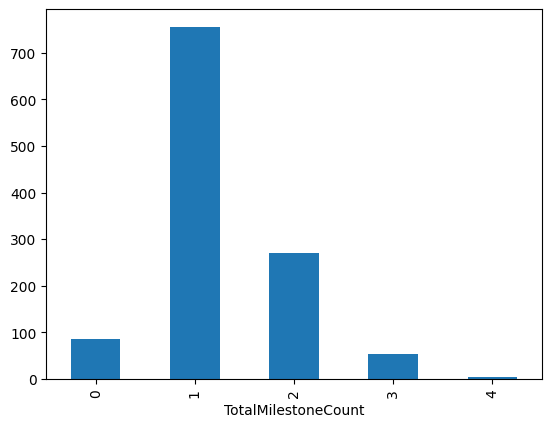

Outlier count: 5



TotalDonationAmount Column: 

count    1172.000000
mean      167.242491
std       334.032023
min         0.000000
25%         0.000000
50%         0.000000
75%       172.990000
max      2687.800000
Name: TotalDonationAmount, dtype: float64
Median: 0.0
IQR: 172.99
Stdev: 333.88948787472737
Skew: 2.9119070685149966


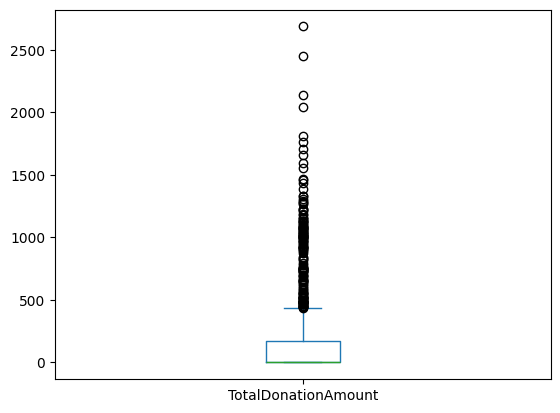

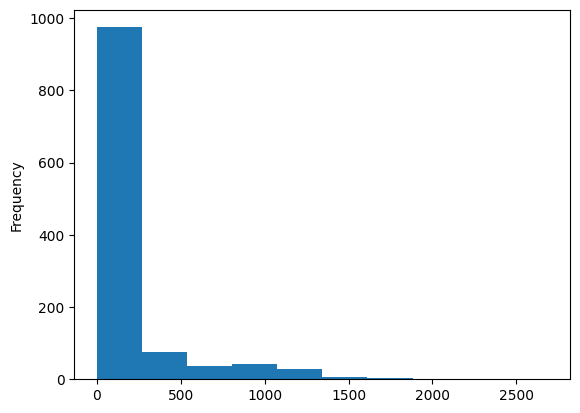

Outlier count: 154



TotalEventsAttended Column: 

count    1172.000000
mean        1.436007
std         1.161656
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: TotalEventsAttended, dtype: float64
Median: 1.0
IQR: 1.0
Stdev: 1.161160605675125
Skew: 2.365556444953993


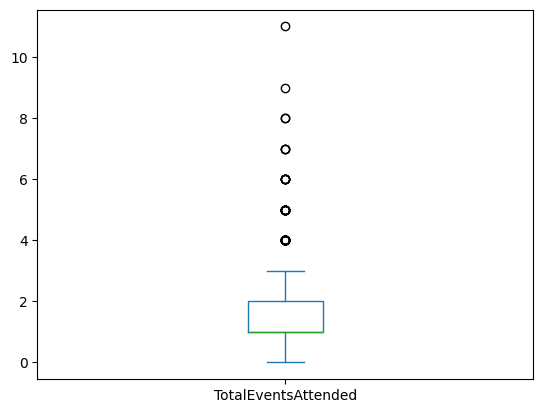

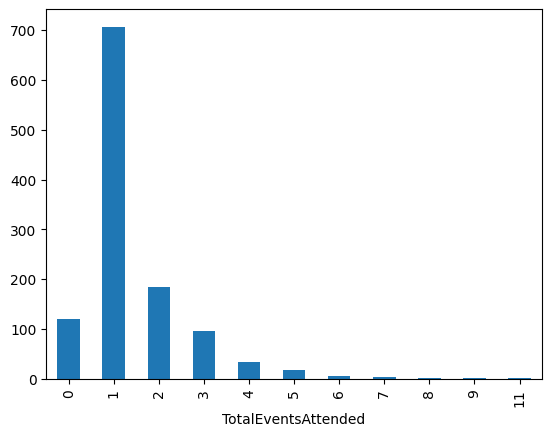

Outlier count: 65



AvgOverallScore Column: 

count    925.000000
mean       4.423993
std        0.276081
min        3.500000
25%        4.250000
50%        4.500000
75%        4.625000
max        5.000000
Name: AvgOverallScore, dtype: float64
Median: 4.5
IQR: 0.375
Stdev: 0.27593189373447147
Skew: -0.402424687802578


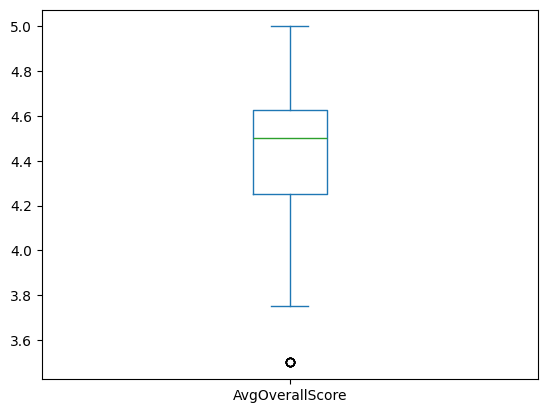

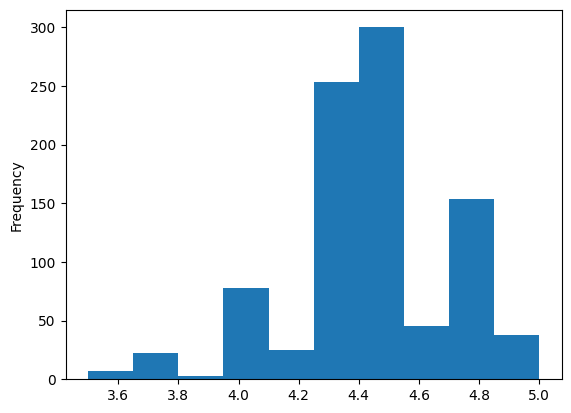

Outlier count: 7



Age Column: 

count    1172.000000
mean       19.610999
std         4.853167
min        10.934976
25%        15.349076
50%        19.798768
75%        23.801506
max        27.909651
Name: Age, dtype: float64
Median: 19.798767967145793
IQR: 8.452429842573581
Stdev: 4.851096444499874
Skew: -0.06868390603052676


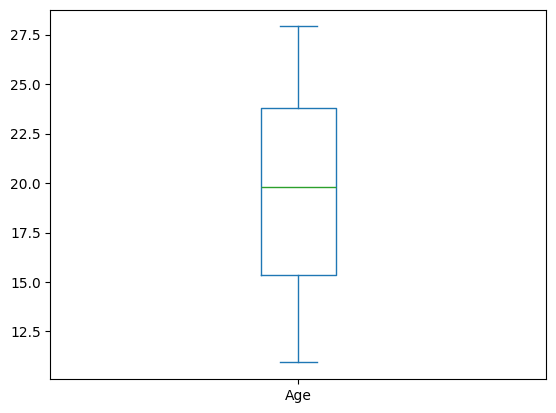

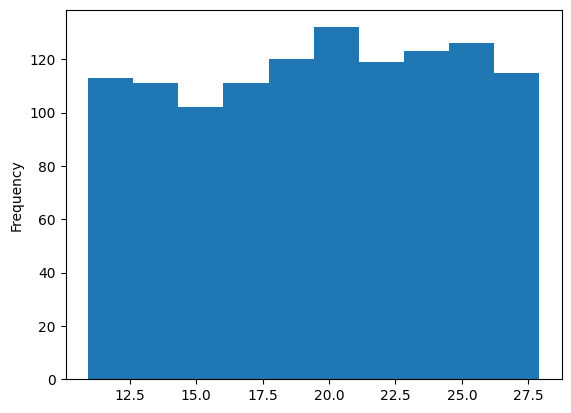

Outlier count: 0





In [ ]:
def univar(columnname):
  print(columnname + " Column: \n")
  print(df[columnname].describe())
  print(f"Median: {df[columnname].median()}")
  first_quart = df[columnname].quantile(0.25)
  third_quart = df[columnname].quantile(0.75)
  iqr = third_quart-first_quart
  stdev = np.std(df[columnname].dropna())
  print(f"IQR: {iqr}")
  print(f"Stdev: {stdev}")
  print(f"Skew: {df[columnname].skew()}")
  histplot = df[columnname].plot(kind='box')
  plt.show()
  if columnname in ["TotalMilestoneCount", "TotalEventsAttended"]:
    df[columnname].value_counts().sort_index().plot(kind='bar')
    plt.show()
  else:
    histplot = df[columnname].plot(kind='hist')
    plt.show()
  num_outliers = df[(df[columnname] > (third_quart + 1.5*iqr)) |
                  (df[columnname] < (first_quart - 1.5*iqr))].shape[0]
  print(f"Outlier count: {num_outliers}")

  print("\n\n")


univar("TotalMilestoneCount")
univar("TotalDonationAmount")
univar("TotalEventsAttended")
univar("AvgOverallScore")
univar("Age")

# Results:
The mean number of milestones is only 1.26 per person, with a median of 1. This indicates a right skew, which is evident in the barplot. The highest number of milestones any individual participant completed was 4. It is helpful to know that most participants completed at least one milestone, but most completed only one or two. <br>
The donation amount data is extremely right skewed. The median donation amount was \$0, indicating that at least half of participants did not donate. Some donated a lot, however, with the mean donation being \$167 and the maximum donation amount being \$2688. <br>
The median number of events attended was 1, indicating that at least half of participants attended 1 or less events. This data was also strongly right skewed, with a mean events attended of 1.44 and a maximum of 11 events attended. <br>
For those that attended events and filled out surveys, their average overall survey score was 4.42. The median survey score was 4.5. There is a slight/moderate left skew in responses. Because the mean and median are so high, we can conclude that the majority of participants that filled out surveys found the events helpful. <br>
Age was evenly distributed between 10 and 27 years old. It is helpful to know the ages of people in our data.


We noticed that these columns had many outliers. However, we believe these outliers are not errors, and thus we decided to keep them in the data.

# Univariate Analysis: Categorical

FieldOfInterest
Both    408
Arts    392
STEM    372
Name: count, dtype: int64


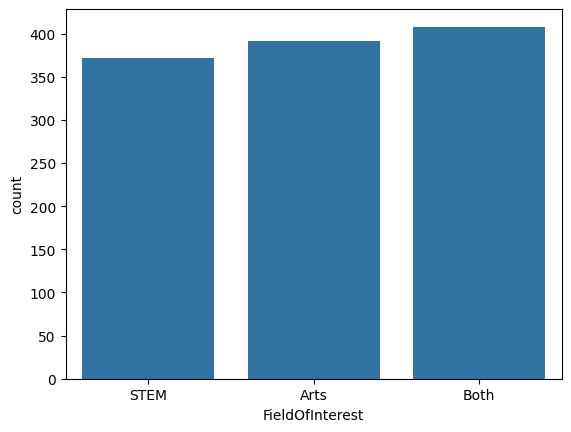

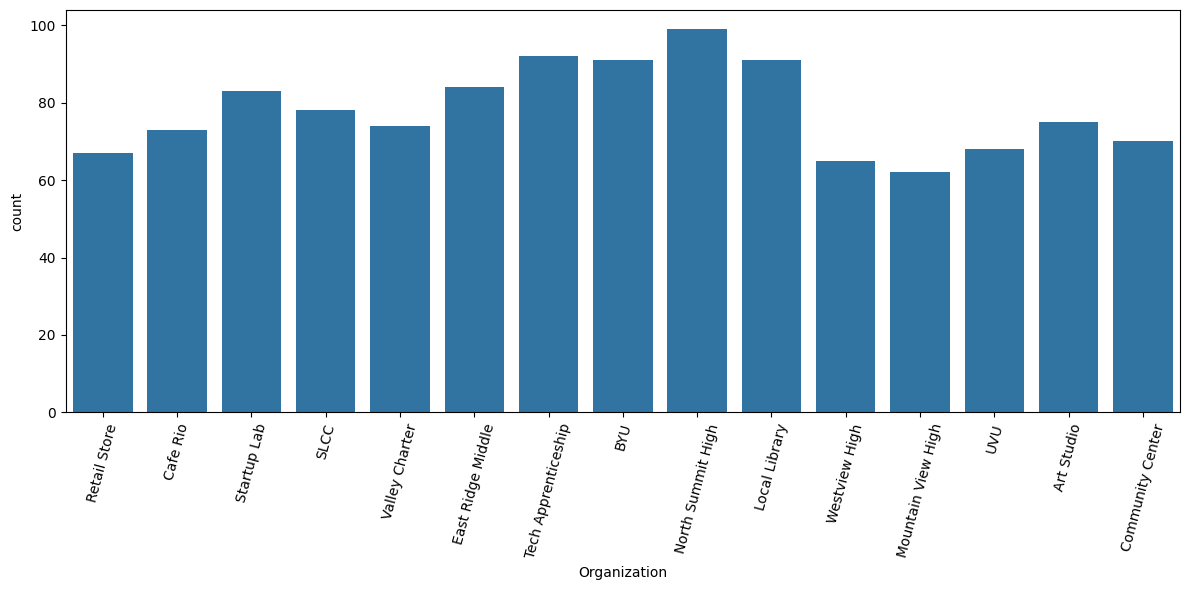

In [ ]:
def cat_univ(catcolumn):
  print(catcolumn.value_counts())
  sns.countplot(x=catcolumn, data=df)

  plt.show()
  print("\n")
print(df["FieldOfInterest"].value_counts())
sns.countplot(x=df["FieldOfInterest"], data=df)
plt.show()
print("\n")
plt.figure(figsize=(12, 6))
sns.countplot(x=df["Organization"], data=df)
plt.xticks(rotation=75)
plt.tight_layout()       # makes sure labels don’t get cut off
plt.show()

plt.show()
print("\n")

# Analysis:
Analyzing these categorical columns gave us some interesting insights. Nearly the same number of participants were interested in STEM, Arts, or Both. Slightly more are interested in Both and Arts than STEM. <br>
We also noticed something very interesting about the "Organization" column. All 1100 participants belong to one of these 15 organizations, with a roughly even distribution across them (hovering between 62 and 99 per organization). We understand that this is likely due to the data being generated for the purpose of this project, although a finding like this in the real world could indicate that we might want to branch out more and cater to other demographics as well.

# Bivariate Analysis

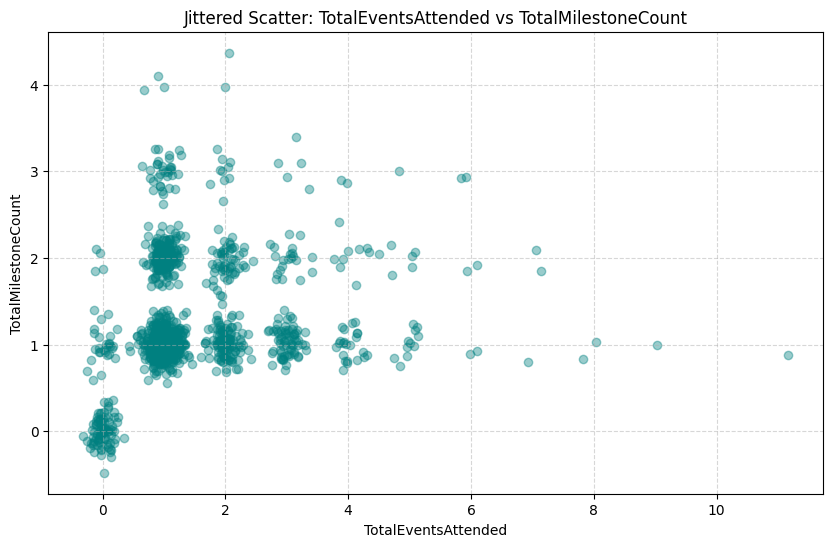

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


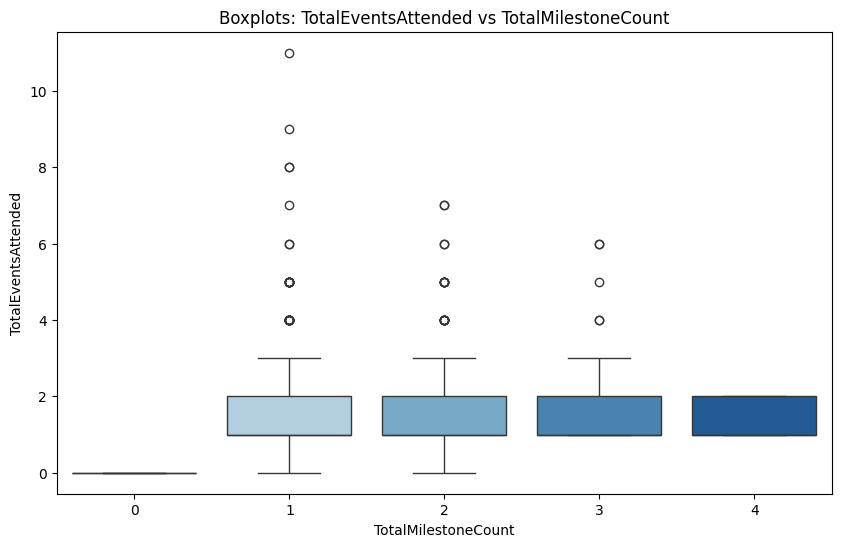

Spearman Correlation:
                      TotalEventsAttended  TotalMilestoneCount
TotalEventsAttended             1.000000             0.314982
TotalMilestoneCount             0.314982             1.000000


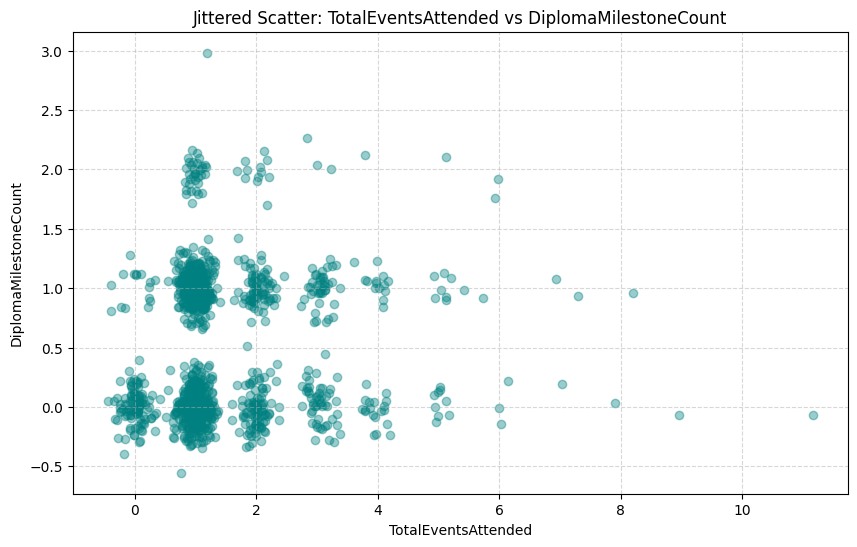

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


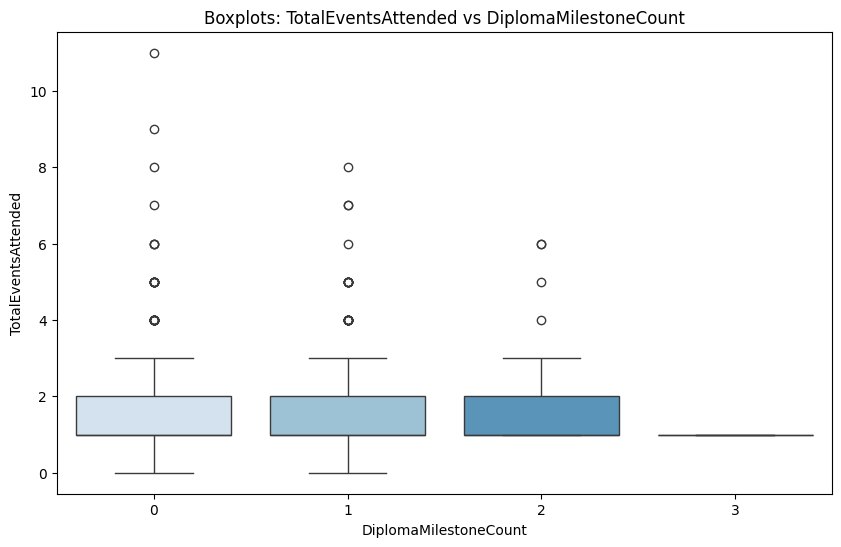

Spearman Correlation:
                        TotalEventsAttended  DiplomaMilestoneCount
TotalEventsAttended                1.00000                0.11353
DiplomaMilestoneCount              0.11353                1.00000


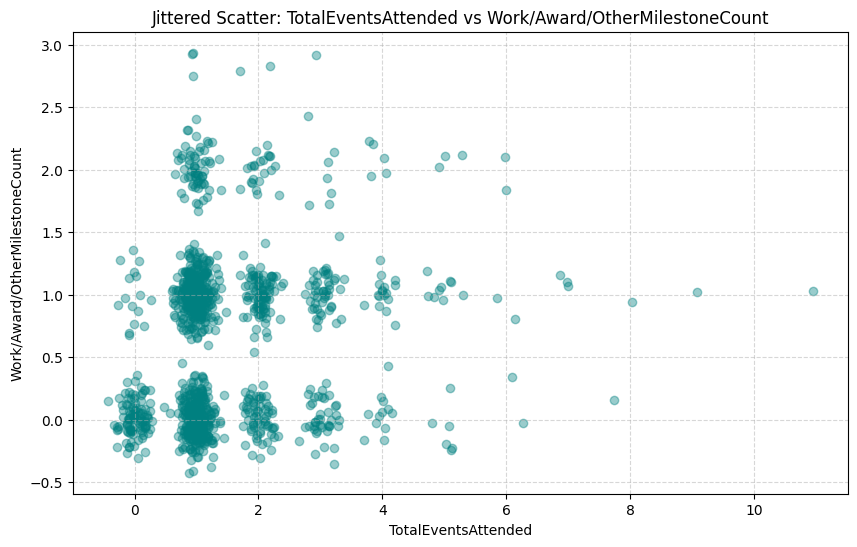

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


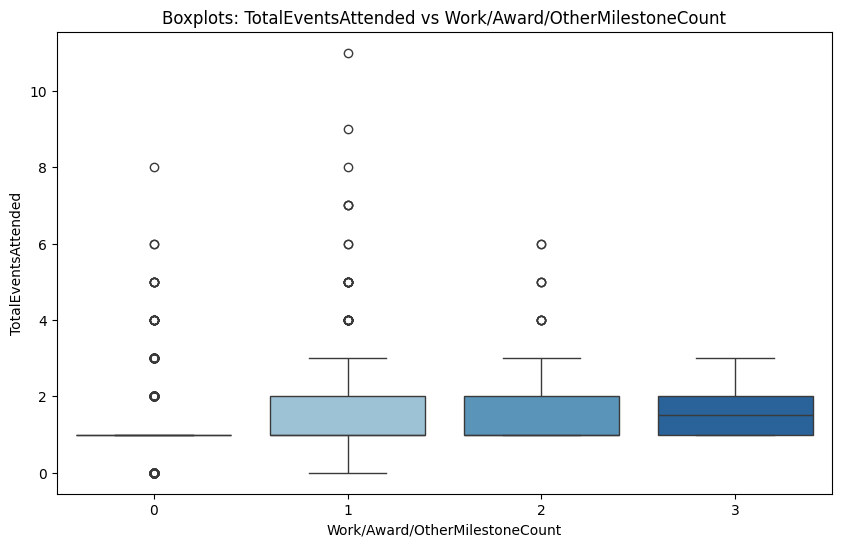

Spearman Correlation:
                                 TotalEventsAttended  \
TotalEventsAttended                        1.000000   
Work/Award/OtherMilestoneCount             0.206271   

                                Work/Award/OtherMilestoneCount  
TotalEventsAttended                                   0.206271  
Work/Award/OtherMilestoneCount                        1.000000  


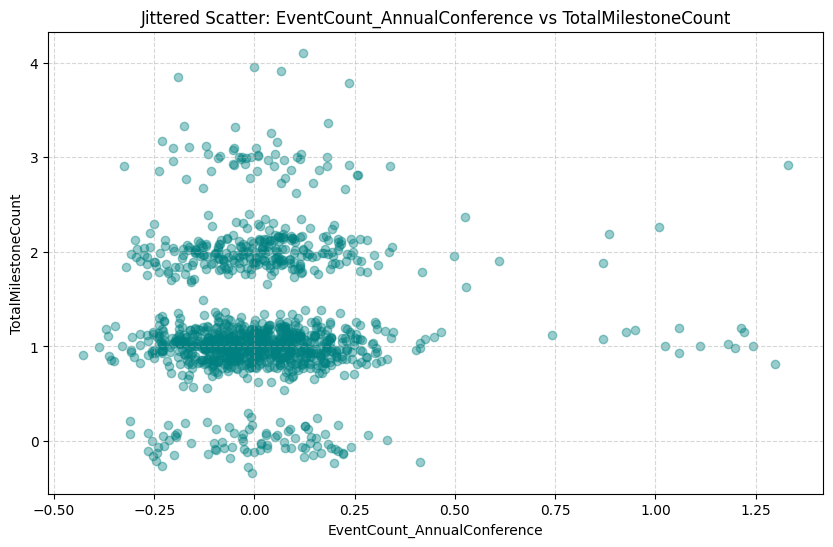

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


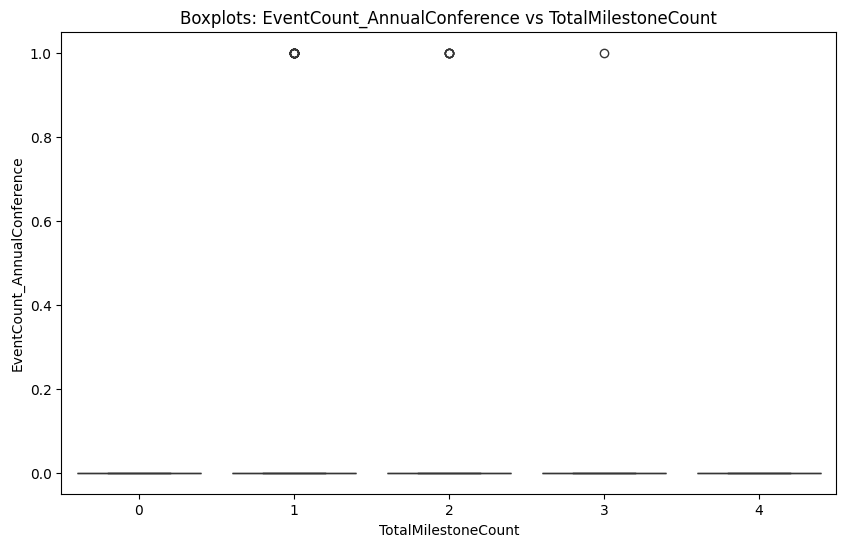

Spearman Correlation:
                              EventCount_AnnualConference  TotalMilestoneCount
EventCount_AnnualConference                     1.000000             0.018455
TotalMilestoneCount                             0.018455             1.000000


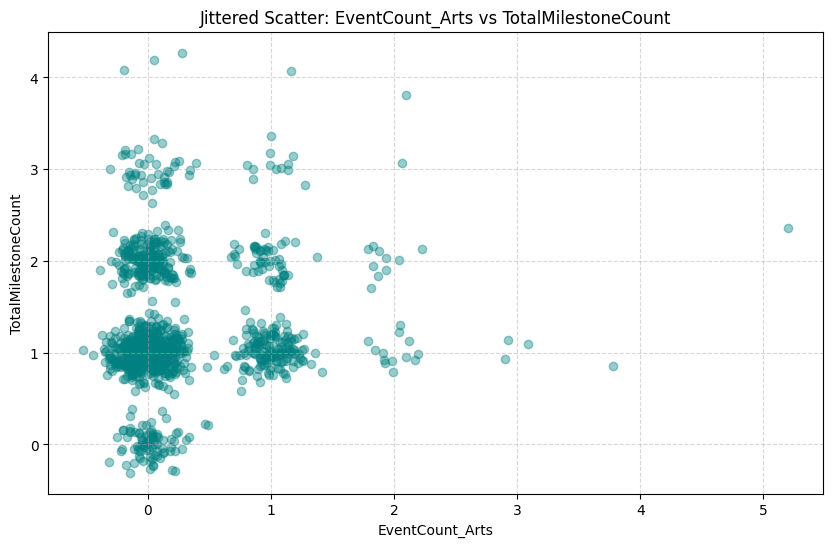

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


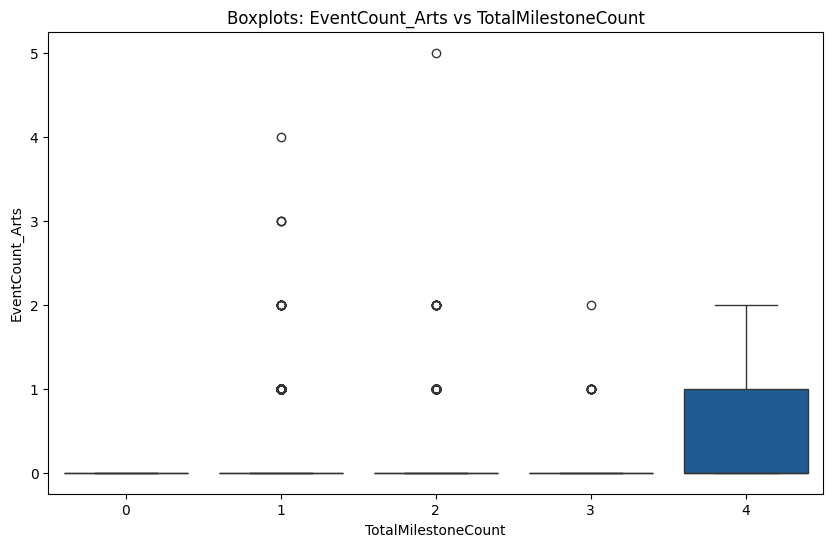

Spearman Correlation:
                      EventCount_Arts  TotalMilestoneCount
EventCount_Arts             1.000000             0.094698
TotalMilestoneCount         0.094698             1.000000


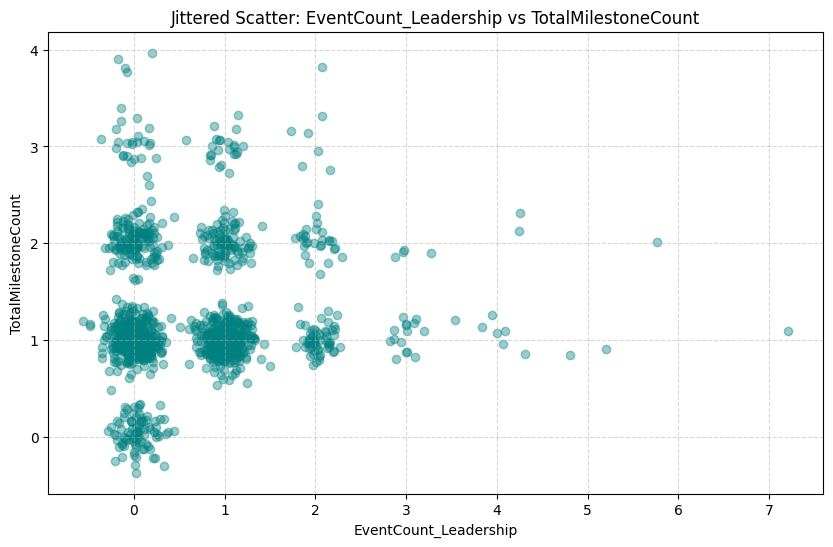

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


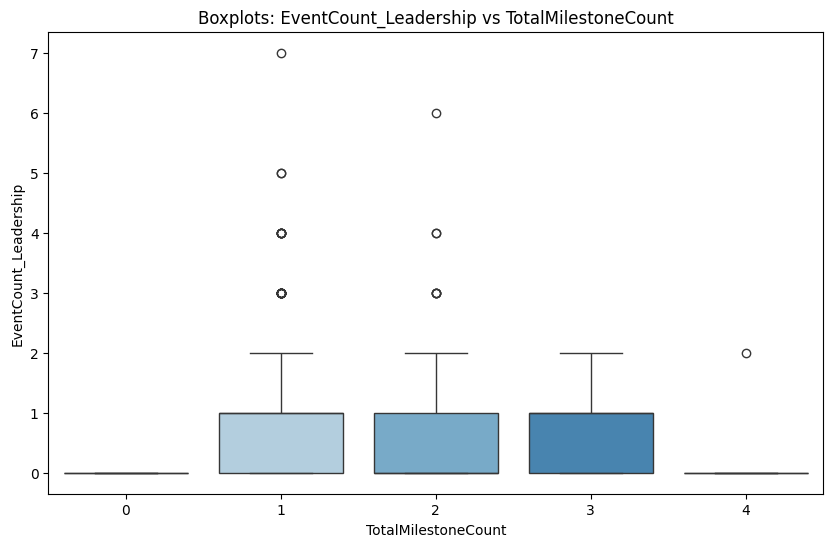

Spearman Correlation:
                        EventCount_Leadership  TotalMilestoneCount
EventCount_Leadership               1.000000             0.110951
TotalMilestoneCount                 0.110951             1.000000


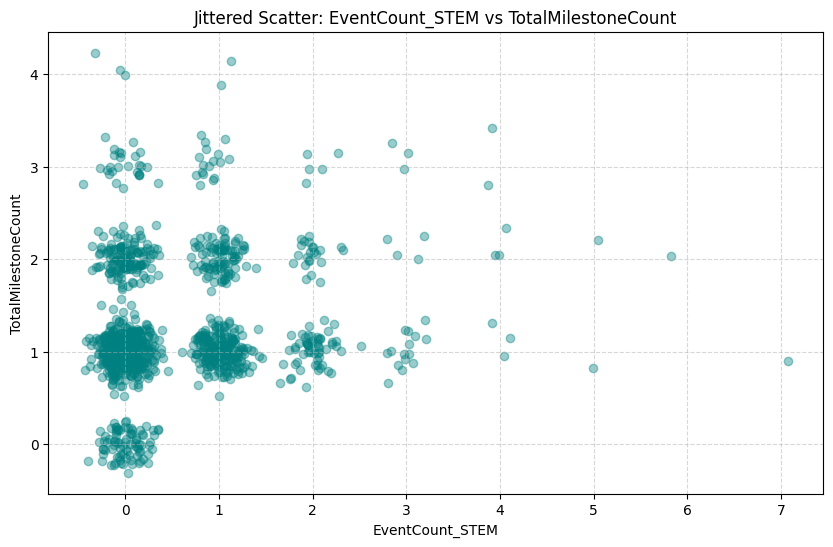

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


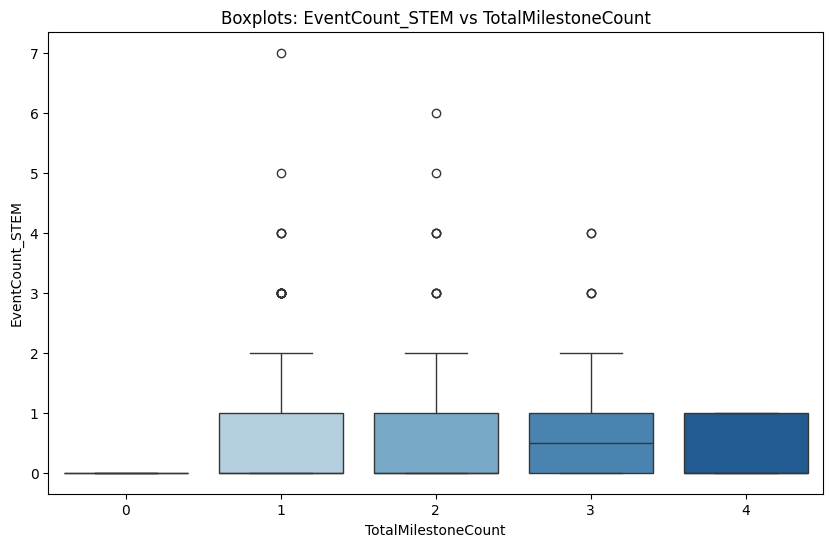

Spearman Correlation:
                      EventCount_STEM  TotalMilestoneCount
EventCount_STEM              1.00000              0.18421
TotalMilestoneCount          0.18421              1.00000


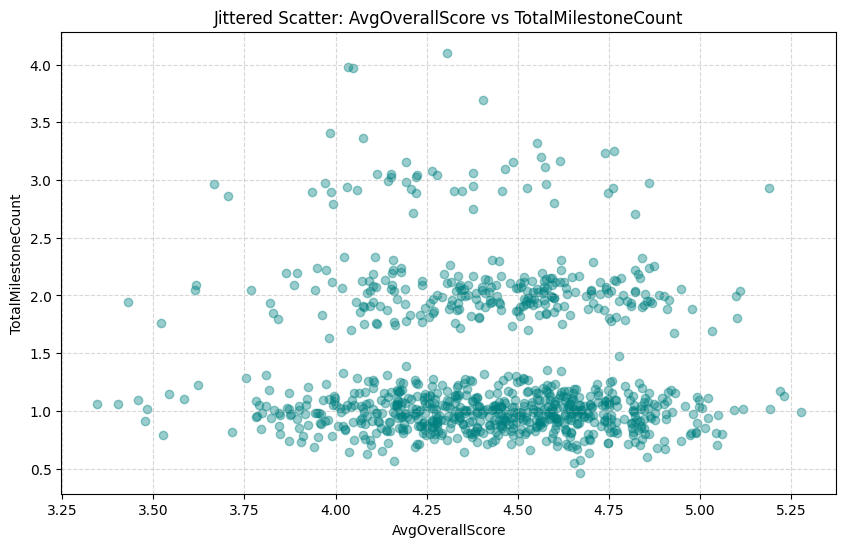

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


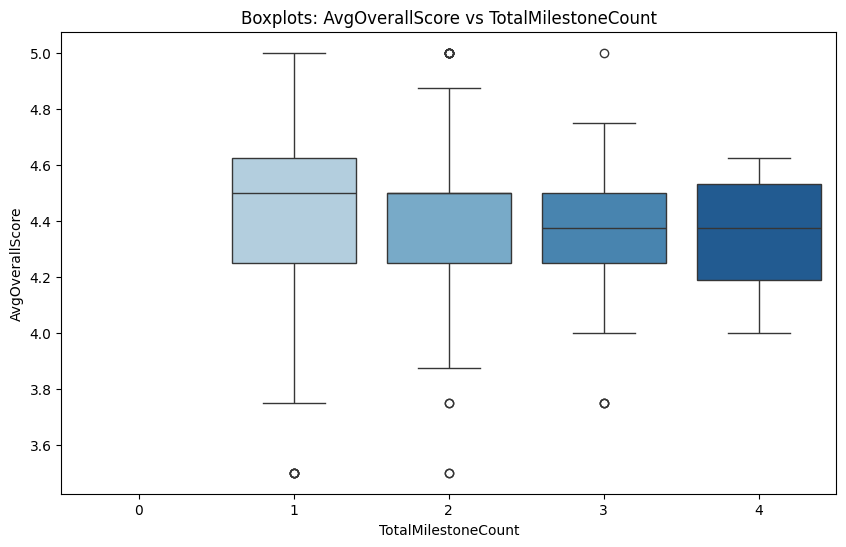

Spearman Correlation:
                      AvgOverallScore  TotalMilestoneCount
AvgOverallScore             1.000000            -0.027325
TotalMilestoneCount        -0.027325             1.000000


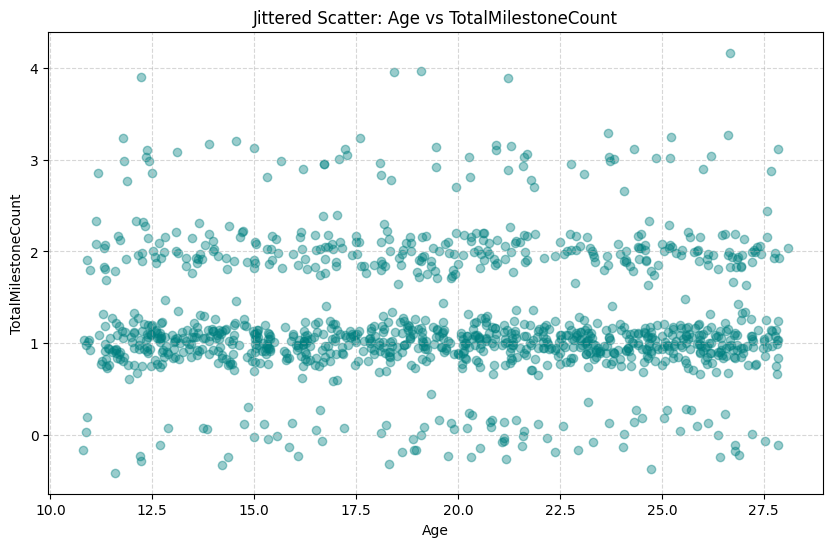

/tmp/ipython-input-554057693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')


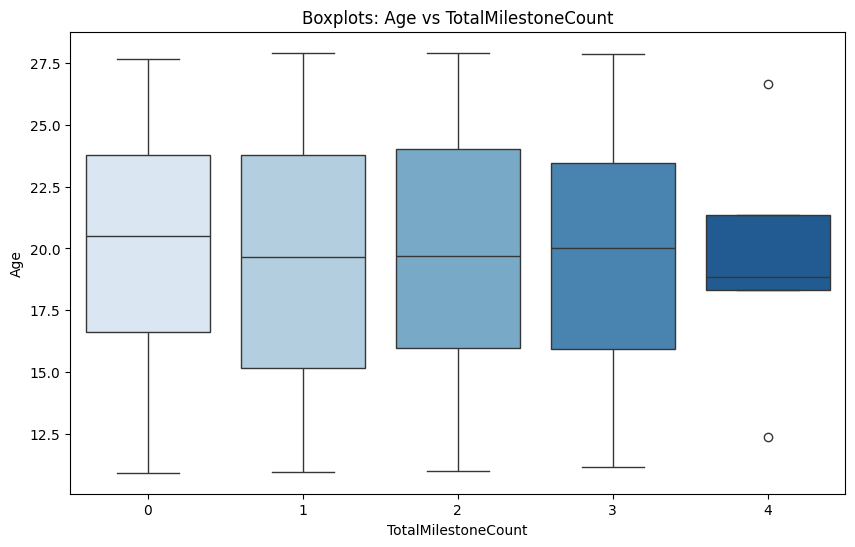

Spearman Correlation:
                           Age  TotalMilestoneCount
Age                  1.000000            -0.005744
TotalMilestoneCount -0.005744             1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# A. Jittered Scatter Plot
# (We add random noise just for the plot so dots don't hide each other)
def jitteredplots(independent, dependent):
  plt.figure(figsize=(10, 6))
  jitter_x = df[independent] + np.random.normal(0, 0.15, len(df))
  jitter_y = df[dependent] + np.random.normal(0, 0.15, len(df))

  plt.scatter(jitter_x, jitter_y, alpha=0.4, color='teal')
  plt.title(f"Jittered Scatter: {independent} vs {dependent}")
  plt.xlabel(independent)
  plt.ylabel(dependent)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.show()

  # B. Box Plot (The Best Option)
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=dependent, y=independent, data=df, palette='Blues')
  plt.title(f"Boxplots: {independent} vs {dependent}")
  plt.xlabel(dependent)
  plt.ylabel(independent)
  plt.show()

  # C. Spearman Correlation
  corr = df[[independent, dependent]].corr(method='spearman')
  print("Spearman Correlation:\n", corr)




jitteredplots("TotalEventsAttended", "TotalMilestoneCount")
jitteredplots("TotalEventsAttended", "DiplomaMilestoneCount")
jitteredplots("TotalEventsAttended", "Work/Award/OtherMilestoneCount")
jitteredplots("EventCount_AnnualConference", "TotalMilestoneCount")
jitteredplots("EventCount_Arts", "TotalMilestoneCount")
jitteredplots("EventCount_Leadership", "TotalMilestoneCount")
jitteredplots("EventCount_STEM", "TotalMilestoneCount")
jitteredplots("AvgOverallScore", "TotalMilestoneCount")
jitteredplots("Age", "TotalMilestoneCount")


# Insights:
We ran some correlation tests and created some jittered scatter plots on our numeric data, comparing our event attendance count columns to our milestone count columns. We also compared average overall survey score to total milestone count. This type of test ignores null values so this is ok given that we have null rows for average overall survey score. We also compared age (calculated from date of birth) to total milestones completed. <br>
We used the Spearman Correlation instead of Pearson Correlation because the values for events attended and milestones were discrete. It is used for count data. The Pearson correlation assumes the variables are continuous, which isn't the case here with event counts and milestone counts.We also created boxplot graphs to better visualize potential correlations.<br>
## Findings:
Among all of the comparisons we did, we didn't find any very significant correlations. The highest correlated variables we detected were Total Events Attended and Total Milestones, with a correlation of 0.315 which is a moderate correlation. The next highest correlation was Total Events Attended with Work/award/other milestones with 0.206 which is a low correlation. The rest of the variables had even lower correlations. We conclude that the number of milestones a participant completes is slightly related to the number of events they attend. The other variables don't really relate to number of milestones completed.<br>
The most interesting insight we found was that age had no correlation with total milestones completed. It would be expected that an older person would have completed more life milestones than a younger person. This could indicate either a data gathering error or analysis error. The participants also may misunderstand when/if to enter a life milestone. This is definitely something to keep in mind in our analysis.

Barplot for FieldOfInterest and TotalMilestoneCount: 


/tmp/ipython-input-1645605839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')


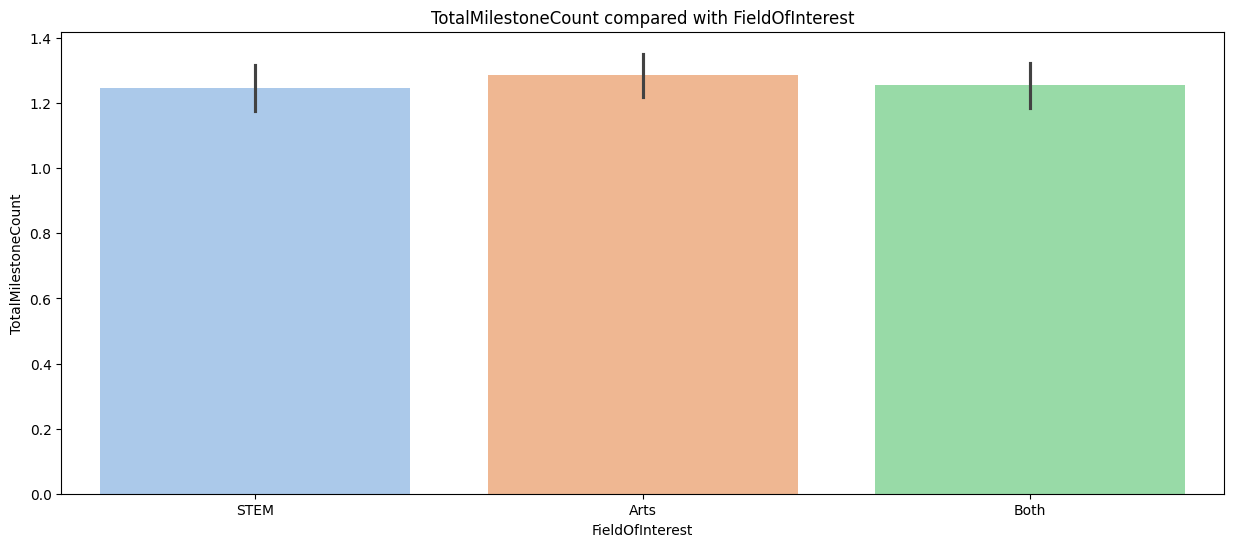

Anova test for FieldOfInterest & TotalMilestoneCount
F: 0.3490339
p: 0.7054427
Barplot for FieldOfInterest and ProjectMilestoneCount: 


/tmp/ipython-input-1645605839.py:12: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f, p =  stats.f_oneway(*group_labels)
/tmp/ipython-input-1645605839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')


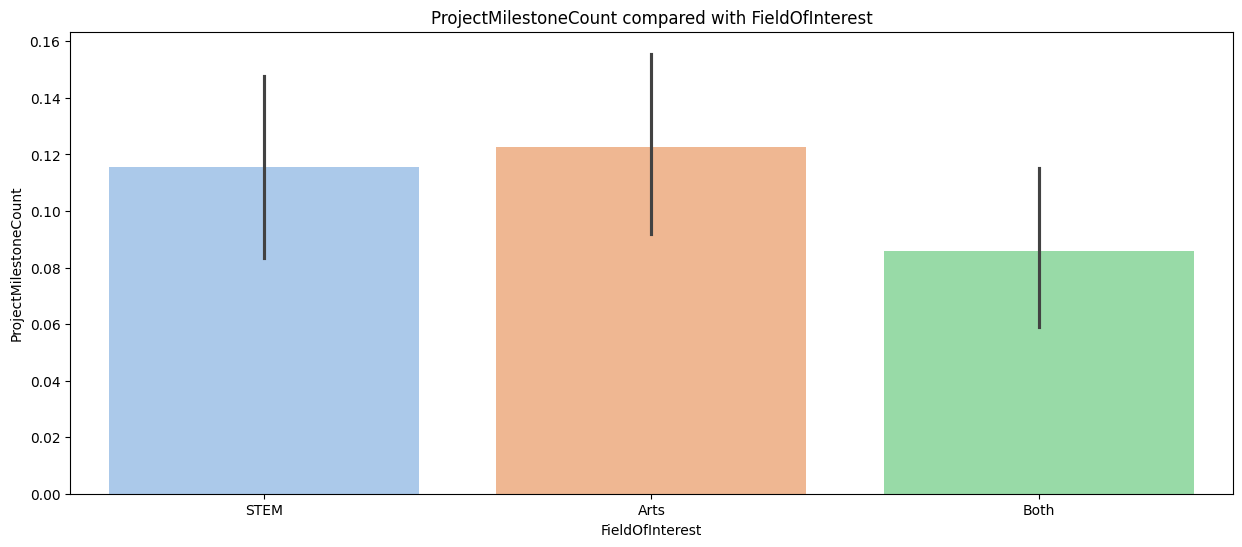

Anova test for FieldOfInterest & ProjectMilestoneCount
F: 1.5862449
p: 0.2051331
Barplot for FieldOfInterest and Work/Award/OtherMilestoneCount: 


/tmp/ipython-input-1645605839.py:12: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f, p =  stats.f_oneway(*group_labels)
/tmp/ipython-input-1645605839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')


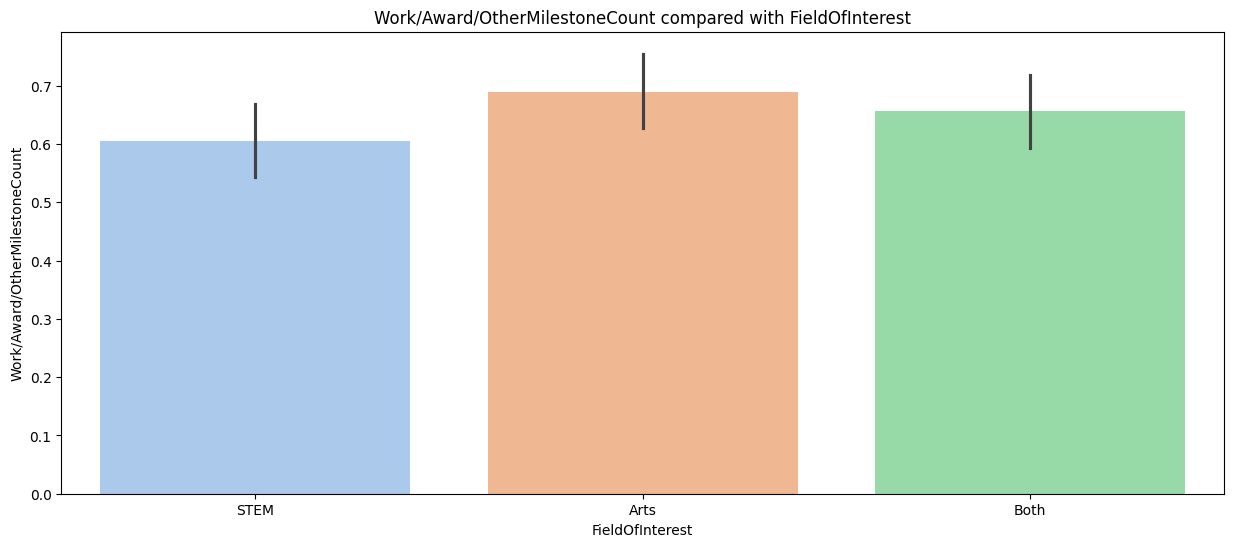

Anova test for FieldOfInterest & Work/Award/OtherMilestoneCount
F: 1.5814461
p: 0.2061172
Barplot for FieldOfInterest and DiplomaMilestoneCount: 


/tmp/ipython-input-1645605839.py:12: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f, p =  stats.f_oneway(*group_labels)
/tmp/ipython-input-1645605839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')


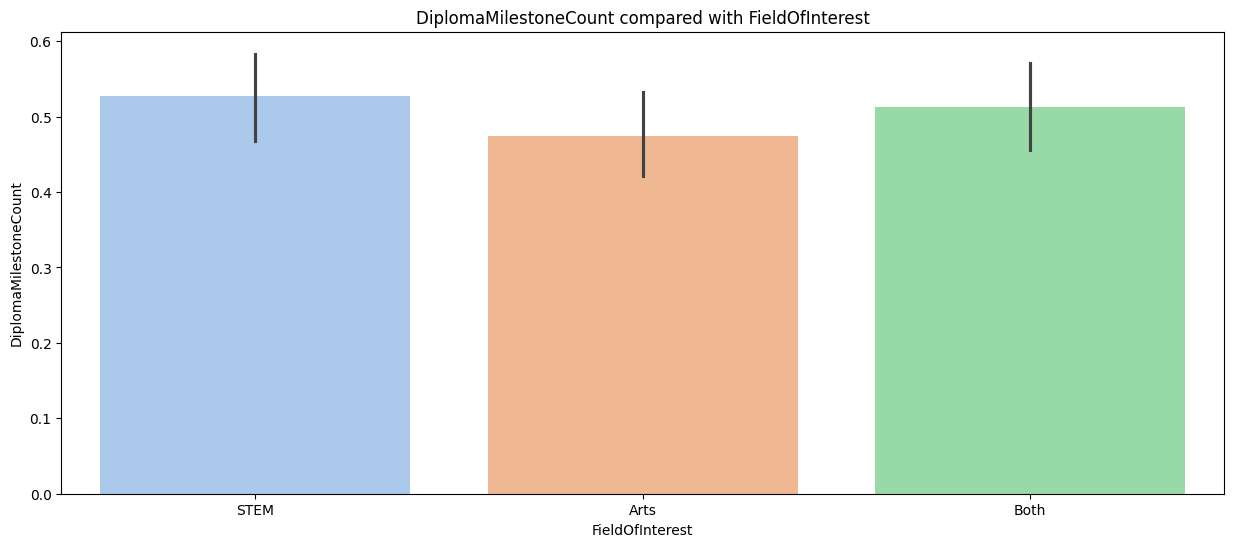

Anova test for FieldOfInterest & DiplomaMilestoneCount
F: 0.8149498
p: 0.4429129
Barplot for City and TotalMilestoneCount: 


/tmp/ipython-input-1645605839.py:12: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f, p =  stats.f_oneway(*group_labels)
/tmp/ipython-input-1645605839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')


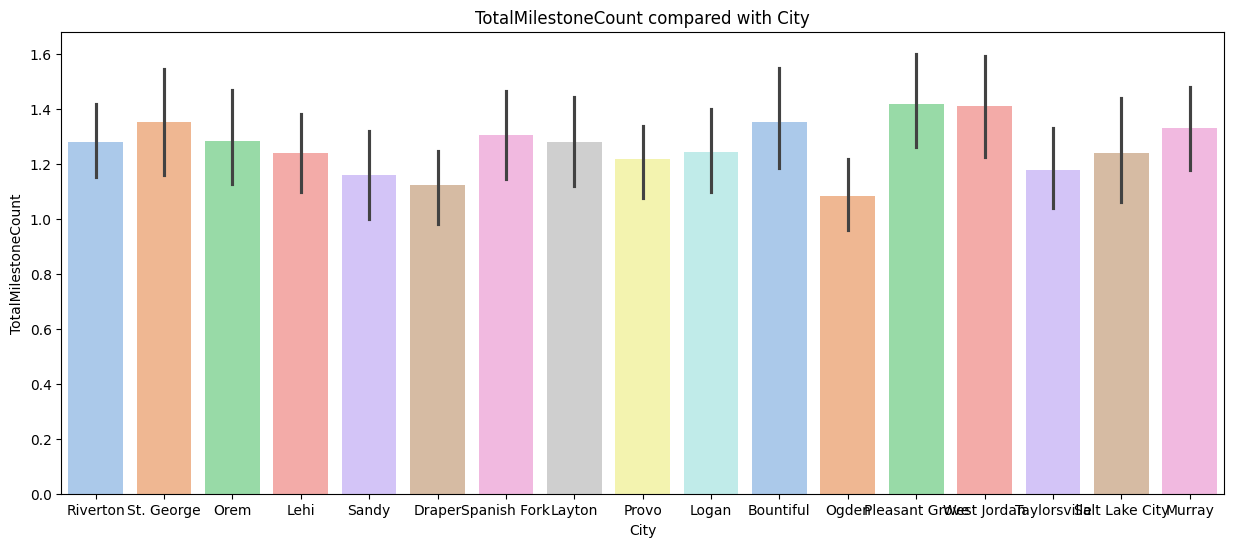

Anova test for City & TotalMilestoneCount
F: 1.3215702
p: 0.1754357
Barplot for Organization and TotalMilestoneCount: 


/tmp/ipython-input-1645605839.py:12: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f, p =  stats.f_oneway(*group_labels)
/tmp/ipython-input-1645605839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')


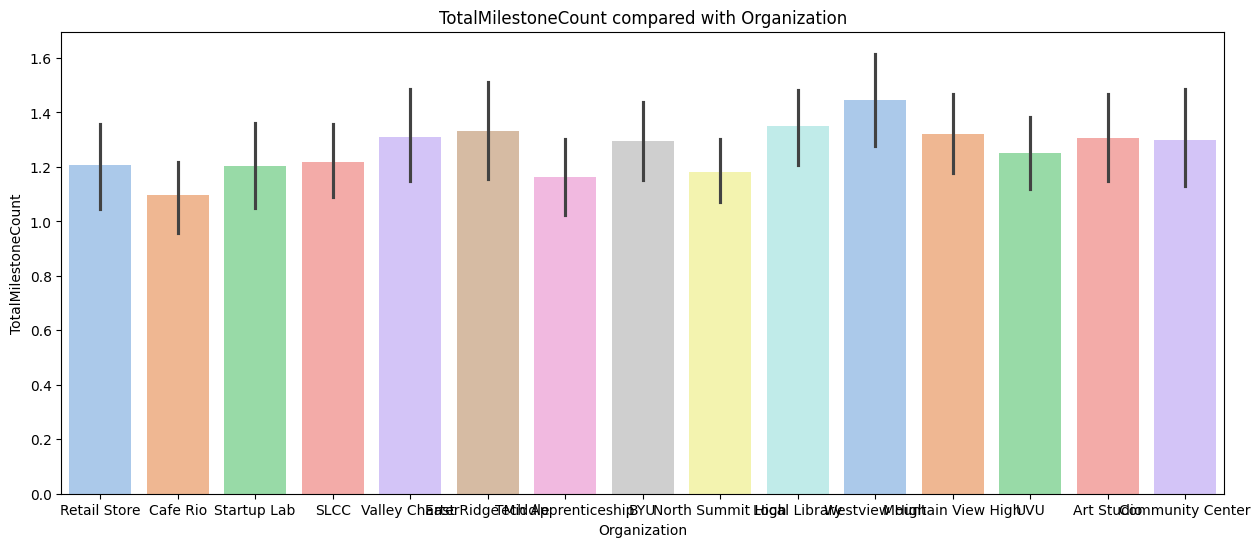

Anova test for Organization & TotalMilestoneCount
F: 1.2971293
p: 0.201728


/tmp/ipython-input-1645605839.py:12: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f, p =  stats.f_oneway(*group_labels)


In [ ]:
def anova(df, anovacolumn, dependent):
  print(f"Barplot for {anovacolumn} and {dependent}: ")
  plt.figure(figsize=(15, 6))
  sns.barplot(x = anovacolumn, y = dependent, data = df, palette='pastel')
  plt.title(f"{dependent} compared with {anovacolumn}")
  plt.show()
  print(f"Anova test for {anovacolumn} & {dependent}")
  groups = df[anovacolumn].unique()
  group_labels = []
  for g in groups:
    group_labels.append(df[df[anovacolumn] == g][dependent])
  f, p =  stats.f_oneway(*group_labels)

  print('F: ' + str(round(f, 7)))
  print('p: ' + str(round(p, 7)))

def tukeytest(df, columnname, dependent):
  print(f"Tukey test for {columnname} & {dependent}")
  tukey = pairwise_tukeyhsd(endog=df[dependent],
                            groups=df[columnname],
                            alpha=0.05)
  print(tukey)


anova(df, "FieldOfInterest", "TotalMilestoneCount")
anova(df, "FieldOfInterest", "ProjectMilestoneCount")
anova(df, "FieldOfInterest", "Work/Award/OtherMilestoneCount")
anova(df, "FieldOfInterest", "DiplomaMilestoneCount")
anova(df, "City", "TotalMilestoneCount")
anova(df, "Organization", "TotalMilestoneCount")



# Analysis:
We ran anova tests comparing number of milestones achieved total and by category with fields of interest. We wanted to know if field of interest was associated with milestones completed. We also compared city and organization to number of milestones to see if there was any relationship.
## Results:
All of our ANOVA tests returned p-values that were not significant. Because of this, we didn't run Tukey tests because we already knew that the results would not be significant. We conclude that we are unable to determine any meaningful relationships or differences between milestones achieved and fields of interest or city or organization.

# Conclusion:
Although our bivariate analysis didn't reveal any meaningful relationships between variables that could help determine what influences milestones (aside from a moderate correlation of events attended and total milestones), we still gained useful information in this analysis. For example, we know that there wouldn't be a clear benefit to focusing on a particular organization, city, or field of interest to influence milestones. This way we don't expend resources in fruitless efforts. We definitely should check our data collection though to better understand why older individuals haven't completed more milestones.